In [50]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
import control
from scipy.optimize import curve_fit

Descomentar linha para executar gráficos em $\LaTeX$.

In [306]:
# DESCOMENTAR NO FIM PARA GRAVAR PLOTS EM LATEX. DEMORAM MAIS A GERAR
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = ['Computer Modern Roman']
#plt.rcParams['text.usetex'] = True
#
#plt.rcParams['font.size'] = 30
#plt.rcParams['axes.labelsize'] = 35
#plt.rcParams['axes.linewidth'] = 1.5

# 1ª Sessão

### Secção Biquadrática de Kerwin, Huelsman e Newman (KHN)

Definição dos parâmetros dos componentes usados:

In [22]:
k   = 1e3
M   = 1e6
n   = 1e-9

C1  = 4.7*n
C2  = 4.7*n

P1  = 100*k
P2  = 10*k

R1  = 51*k
R2  = 100*k
R3  = 10*k
R4  = 10*k
R5  = 100*k
R6  = 10*k
R7  = 1*M
R8  = 100*k
R9  = 51*k
R10 = 100*k
R11 = 10*k

In [23]:
def convert_to_dB(w):
    return [20*(np.log10(abs(i))) for i in w]

Definição do Ganho, frequência proibida e fator de qualidade: 

In [24]:
K  = (P2/(R3 + P2))*(1 + R5/R2)

wp = np.sqrt(R5/(R2*C1*C2*R6*R11))

Q  = np.sqrt(R5/(R2*C1*C2*R6*R11))/((R3/((R3+R3)*C1*R6))*(1+R5/R2))

Funções de Transferência

In [25]:
def T1(s):
    return (K*s**2)/(s**2 + s * wp/Q + wp**2)

def T2(s):
    return (K*s*wp)/(s**2 + s * wp/Q + wp**2)

def T3(s):
    return (K*wp**2)/(s**2 + s * wp/Q + wp**2)

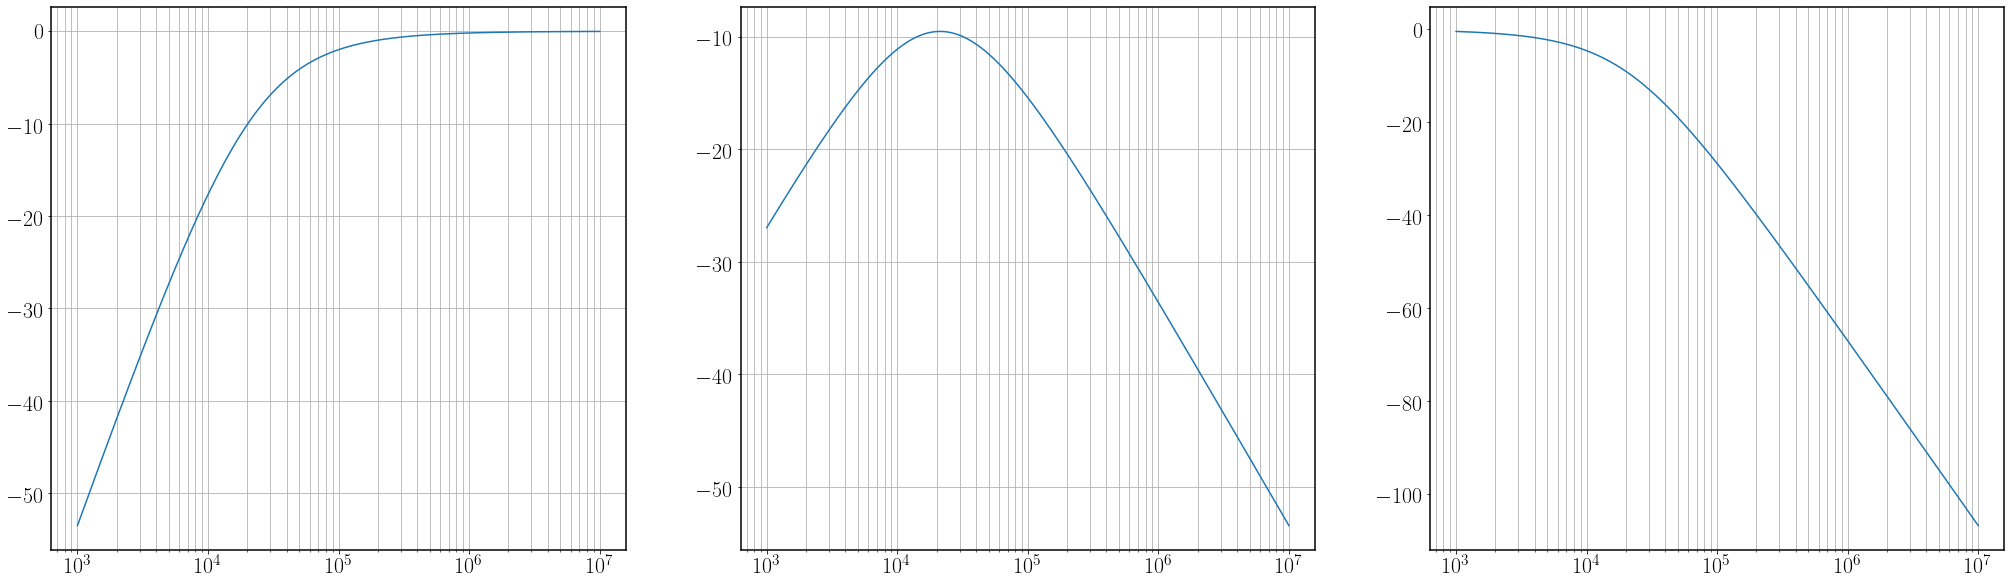

In [26]:
plt.rcParams.update({'font.size': 22})

s = np.linspace(1e3, 1e7, 1e5)
fig = plt.figure()
fig.set_size_inches(35, 10)


ax1 = fig.add_subplot(1, 3, 1)

ax1.set_xscale('log')
ax1.grid(True, which="both")
ax1.plot(s, convert_to_dB(T1(s)))


ax2 = fig.add_subplot(1, 3, 2)

ax2.set_xscale('log')
ax2.grid(True, which="both")
ax2.plot(s, convert_to_dB(T2(s)))


ax3 = fig.add_subplot(1, 3, 3)

ax3.set_xscale('log')
ax3.grid(True, which="both", axis='x')
ax3.plot(s, convert_to_dB(T3(s)))

## Dados Experimentais

In [29]:
def fit_func(x, p0, p1, p2, p3):
    return p0*np.sin(p1*x + p2) + p3

CORRER AS PRÓXIMAS 3 CÉLULAS ANTES Do PLOT DE CADA GRÁFICO.

NÃO ESQUECER DE MUDAR A VARIÁVEL 'ch_out' PARA CADA CASO

In [118]:
path = '/Users/thomasgaehtgens/BIBLIOTECA/MEFT/EG/LABS/LAB - 1/DADOS/DADOS GRUPO 7 6a.xlsx'

db     = pd.ExcelFile(path)
sheets = dict() #DICIONÁRIO COM AS FOLHAS

for freq in db.sheet_names:
    data = db.parse(freq)[['Time (Secs)', 'CHAN1', 'CHAN2', 'CHAN3', 'CHAN4']]
    sheets[freq] = data
    
sheet_names = [freq[:-2] for freq in db.sheet_names]

freqs = list() #LISTA COM OS VALORES DE FREQUÊNCIA
for freq in sheet_names:
    if freq[-1] == 'K':
        freqs.append(float(freq[:-1])*1e3)
    else:
        freqs.append(float(freq))

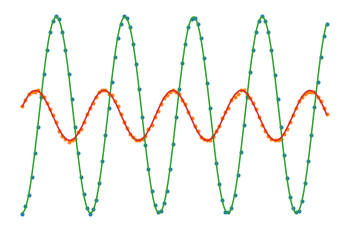

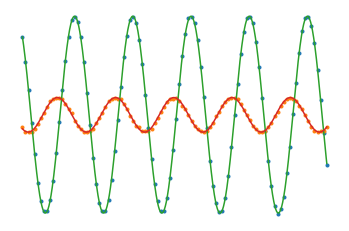

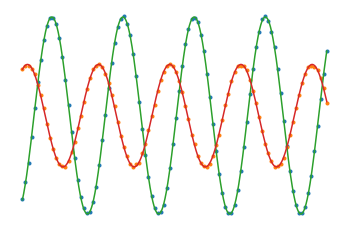

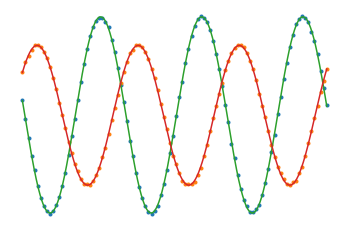

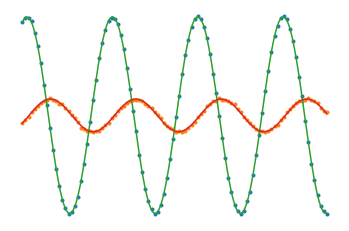

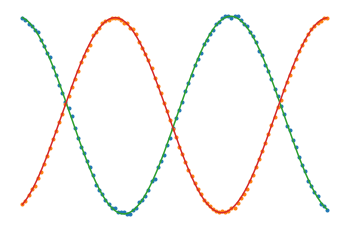

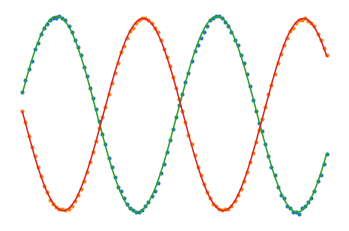

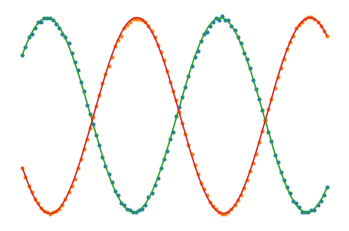

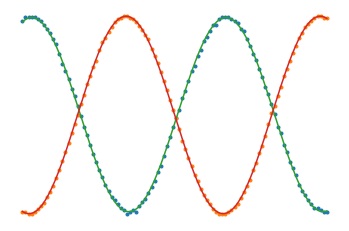

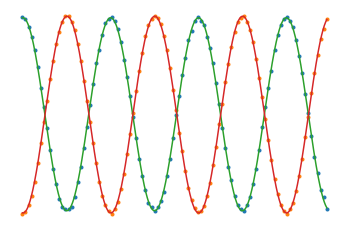

In [111]:
ch_in  = 'CHAN1'
ch_out = 'CHAN3'

AMPS   = list()
i=0
for freq in db.sheet_names:
    fig = plt.figure()
    plt.axis(False)
    
    data = sheets[freq] 
    
    popti, pcov = curve_fit(fit_func, data['Time (Secs)'], data[ch_in] , p0=[0.5, 6*freqs[i], 0, 0])
    popto, pcov = curve_fit(fit_func, data['Time (Secs)'], data[ch_out], p0=[0.5, 6*freqs[i], 0, 0])

    plt.plot(data['Time (Secs)'], data[ch_in] , '.', label=ch_in )
    plt.plot(data['Time (Secs)'], data[ch_out], '.', label=ch_out)
    
    db_time = list(data['Time (Secs)'])
    time = np.linspace(db_time[0], db_time[-1], 1000)

    plt.plot(time, fit_func(time, popti[0], popti[1], popti[2], popti[3]))
    plt.plot(time, fit_func(time, popto[0], popto[1], popto[2], popto[3]))
    
    AMPS.append(abs(popti[0])/abs(popto[0]))
    
    i += 1

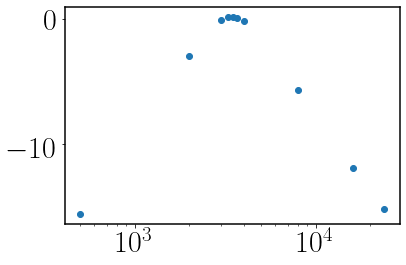

In [112]:
AMPS = [y for x,y in sorted(zip(freqs,AMPS))]
freqs.sort()

fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(freqs, [-20*np.log10(AMP) for AMP in AMPS], 'o')

## Plots

Usando a biblioteca fixe

### T1(s)

In [91]:
G = control.tf([K, 0, 0],[1,wp/Q, wp**2])
print(G)


             s^2
-----------------------------
s^2 + 2.128e+04 s + 4.527e+08



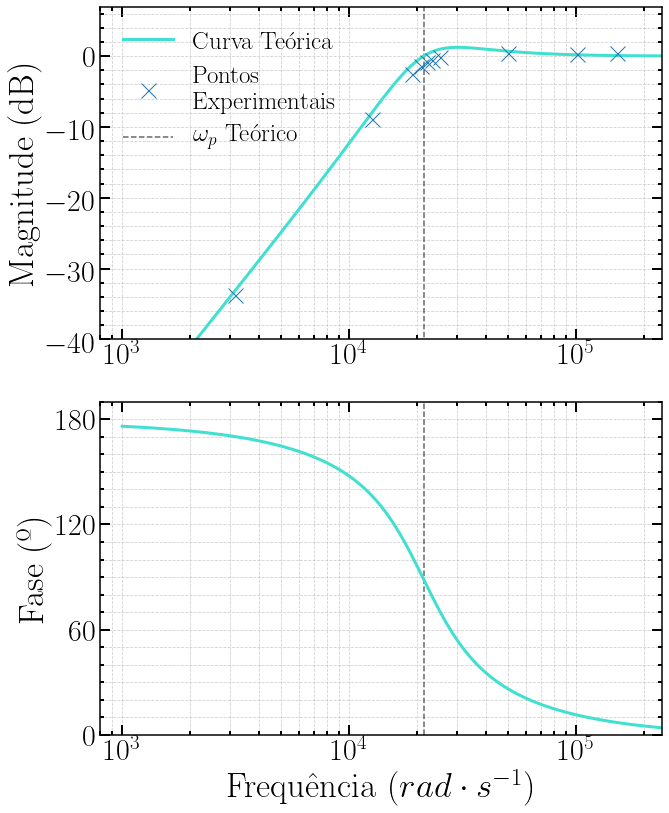

In [101]:
mag,phase,omega = control.bode(G, dB=True, plot=False)
phase = phase - [phase[-1]]

fig = plt.figure()
fig.set_size_inches(10, 12)

ax1 = fig.add_subplot(2, 1, 1)
#plt.title('Diagrama de Bode')

ax2 = fig.add_subplot(2, 1, 2)
plt.xlabel(r'Frequência ($rad \cdot s^{-1}$)')

#RESULTADOS TEÓRICOS
ax1.plot(omega, 20*np.log10(mag) , lw=3, color='turquoise', label='Curva Teórica')
ax2.plot(omega, phase*180/(np.pi), lw=3, color='turquoise')
#DADOS EXPERIMENTAIS
ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], 'x', label='Pontos \nExperimentais', markersize=15)

ax1.vlines(wp, -70, 7, lw=1.5, linestyle='--', label=r'$\omega_p$ Teórico', alpha=0.6)
ax1.set_ylim(-40, 7)
ax1.set_xlim(8*1e2, 2.4*1e5)

ax2.vlines(wp, 0, 190, lw=1.5, linestyle='--', alpha=0.6)
ax2.set_ylim(0, 190)
ax2.set_xlim(8*1e2, 2.4*1e5)


#GRAPHICS SHITS
ax1.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax1.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
ax1.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

ax2.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax2.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))

ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(60))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))

ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Fase (º)')

ax1.legend(frameon=False, fontsize = 25, loc = 'upper left')

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.grid(True, which="both", linestyle='--', alpha=0.6)

fig.tight_layout()
fig.savefig('T1.pdf')

## T2(s)

In [114]:
G = control.tf([K*wp, 0],[1,wp/Q, wp**2])
print(G)


         2.128e+04 s
-----------------------------
s^2 + 2.128e+04 s + 4.527e+08



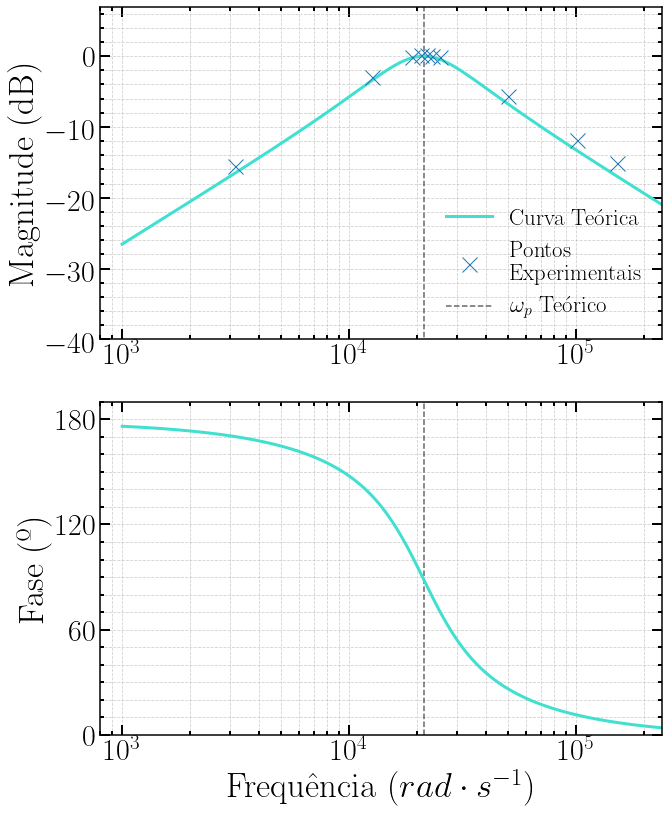

In [115]:
mag,phase,omega = control.bode(G, dB=True, plot=False)
phase = phase - [phase[-1]]

fig = plt.figure()
fig.set_size_inches(10, 12)

ax1 = fig.add_subplot(2, 1, 1)

ax2 = fig.add_subplot(2, 1, 2)
plt.xlabel(r'Frequência ($rad \cdot s^{-1}$)')

#RESULTADOS TEÓRICOS
ax1.plot(omega, 20*np.log10(mag) , lw=3, color='turquoise', label='Curva Teórica')
ax2.plot(omega, phase*180/(np.pi), lw=3, color='turquoise')
#DADOS EXPERIMENTAIS
ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], 'x', label='Pontos \nExperimentais', markersize=15)

ax1.vlines(wp, -70, 7, lw=1.5, linestyle='--', label=r'$\omega_p$ Teórico', alpha=0.6)
ax1.set_ylim(-40, 7)
ax1.set_xlim(8*1e2, 2.4*1e5)

ax2.vlines(wp, 0, 190, lw=1.5, linestyle='--', alpha=0.6)
ax2.set_ylim(0, 190)
ax2.set_xlim(8*1e2, 2.4*1e5)

#GRAPHICS SHITS
ax1.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax1.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
ax1.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

ax2.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax2.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))

ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(60))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))

ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Fase (º)')

ax1.legend(frameon=False, fontsize = 23, loc='lower right')

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.grid(True, which="both", linestyle='--', alpha=0.6)

fig.tight_layout()
fig.savefig('T2.pdf')

## T3(s)

In [106]:
G = control.tf([K*wp**2],[1,wp/Q, wp**2])
print(G)


          4.527e+08
-----------------------------
s^2 + 2.128e+04 s + 4.527e+08



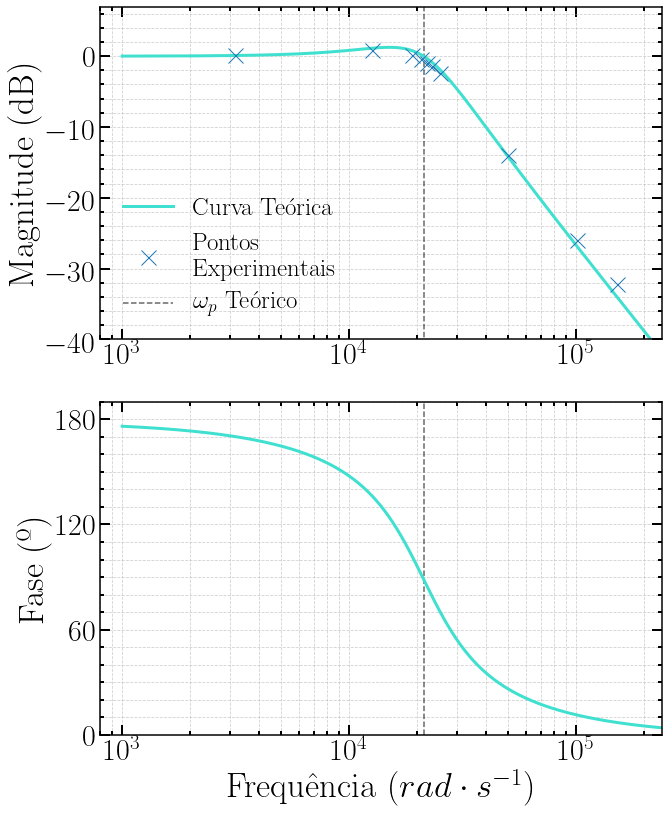

In [108]:
mag,phase,omega = control.bode(G, dB=True, plot=False)
phase = phase - [phase[-1]]

fig = plt.figure()
fig.set_size_inches(10, 12)

ax1 = fig.add_subplot(2, 1, 1)
#plt.title('Diagrama de Bode')

ax2 = fig.add_subplot(2, 1, 2)
plt.xlabel(r'Frequência ($rad \cdot s^{-1}$)')

#RESULTADOS TEÓRICOS
ax1.plot(omega, 20*np.log10(mag) , lw=3, color='turquoise', label='Curva Teórica')
ax2.plot(omega, phase*180/(np.pi), lw=3, color='turquoise')
#DADOS EXPERIMENTAIS
ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], 'x', label='Pontos \nExperimentais', markersize=15)

ax1.vlines(wp, -70, 7, lw=1.5, linestyle='--', label=r'$\omega_p$ Teórico', alpha=0.6)
ax1.set_ylim(-40, 7)
ax1.set_xlim(8*1e2, 2.4*1e5)

ax2.vlines(wp, 0, 190, lw=1.5, linestyle='--', alpha=0.6)
ax2.set_ylim(0, 190)
ax2.set_xlim(8*1e2, 2.4*1e5)


#GRAPHICS SHITS
ax1.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax1.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
ax1.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

ax2.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax2.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))

ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(60))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))

ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Fase (º)')

ax1.legend(frameon=False, fontsize = 25, loc = 'lower left')

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.grid(True, which="both", linestyle='--', alpha=0.6)

fig.tight_layout()
fig.savefig('T3.pdf')

## Identificação do Tipo de Filtragem

In [125]:
wp/2*np.pi #CONVERSÃO RADs^{-1} PARA Hz

33421.1984424446

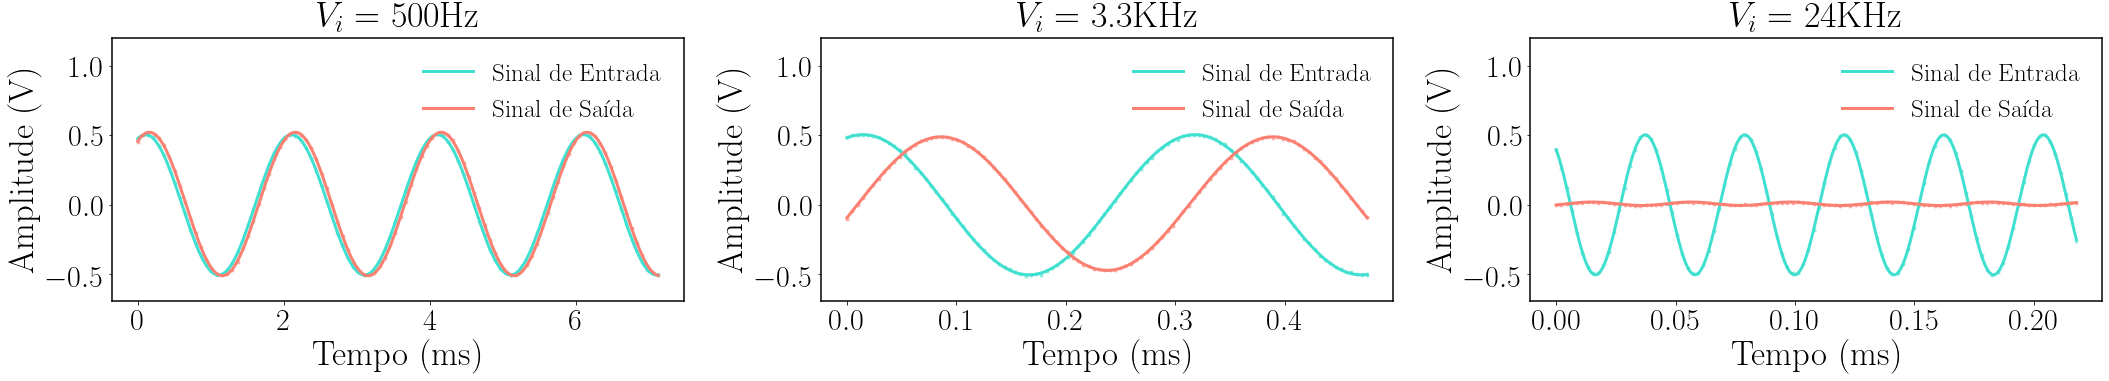

In [216]:
ch_in  = 'CHAN1'
ch_out = 'CHAN4'

freqs_ = [500, 3.3*k, 24*k]
i = 0

fig = plt.figure()
fig.set_size_inches(30, 6)

for freq in ['500HZ', '3.3KHz', '24KHz']:
    ax  = fig.add_subplot(1, 3, i + 1)
    
    data = sheets[freq]
    
    if freq == '500HZ':
        freq = '500Hz'
        
    data_time = 1000*(data['Time (Secs)'] - data['Time (Secs)'][0])
    
    popti, pcov = curve_fit(fit_func, data_time, data[ch_in] , p0=[0.5, 6*freqs_[i]/1000, 0, 0])
    popto, pcov = curve_fit(fit_func, data_time, data[ch_out], p0=[0.5, 6*freqs_[i]/1000, 0, 0])

    ax.plot(data_time, data[ch_in] , '.', color='turquoise', alpha=0.5)
    ax.plot(data_time, data[ch_out], '.', color='salmon'   , alpha=0.5)
    
    time = np.linspace(list(data_time)[0], list(data_time)[-1], 1000)

    ax.plot(time, fit_func(time, popti[0], popti[1], popti[2], popti[3]), color='turquoise', lw = 3, label='Sinal de Entrada')
    ax.plot(time, fit_func(time, popto[0], popto[1], popto[2], popto[3]), color='salmon'   , lw = 3, label='Sinal de Saída')
    
    ax.set_ylim(-0.7, 1.2)
    
    ax.set_xlabel('Tempo (ms)')
    ax.set_ylabel('Amplitude (V)')
    
    ax.set_title(r'$V_{i} = $ ' + freq)
    ax.legend(loc='upper right', frameon=False, fontsize=25)
    
    i += 1

plt.tight_layout()
plt.savefig('T3_FILT.pdf')

# 2ª Sessão - Tow Thomas

In [241]:
def T1(s):
    return -(K*s*wp)/(s**2 + s * wp/Q + wp**2)

def T2(s):
    return (K*wp**2)/(s**2 + s * wp/Q + wp**2)

def T3(s):
    return -(K*wp**2)/(s**2 + s * wp/Q + wp**2)

In [242]:
wp = np.sqrt(R5/(C1*C1*R11*R2*R4))

Q  = wp*C1*R6

K  = 1/(C1*P2*wp)

## Dados Experimentais

$T_{1}(s)$

In [354]:
G1 = control.tf([-K*wp, 0],[1,wp/Q, wp**2])
print(G)


        -4.255e+05 s
-----------------------------
s^2 + 2.128e+04 s + 4.527e+08



$T_{2}(s)$

In [355]:
G2 = control.tf([K*wp**2],[1,wp/Q, wp**2])
print(G)


        -4.255e+05 s
-----------------------------
s^2 + 2.128e+04 s + 4.527e+08



$T_{3}(s)$

In [356]:
G3 = control.tf([-K*wp**2],[1,wp/Q, wp**2])
print(G)


        -4.255e+05 s
-----------------------------
s^2 + 2.128e+04 s + 4.527e+08



In [348]:
paths = ['DADOS/GRUPO 7 2a SESSAO R=10KOhm.xlsx',
         'DADOS/GRUPO 7 2a SESSAO R=5KOhm.xlsx',
         'DADOS/GRUPO 7 2a SESSAO R=1KOhm.xlsx',
         'DADOS/GRUPO 7 2a SESSAO R=0.5KOhm.xlsx']

In [318]:
path  = paths[-1]

db     = pd.ExcelFile(path)
sheets = dict() #DICIONÁRIO COM AS FOLHAS

for freq in db.sheet_names:
    data = db.parse(freq)[['Time (Secs)', 'CHAN1', 'CHAN2', 'CHAN3', 'CHAN4']]
    sheets[freq] = data
    
sheet_names = [freq[:-2] for freq in db.sheet_names]

freqs = list() #LISTA COM OS VALORES DE FREQUÊNCIA
for freq in sheet_names:
    if freq[-1] == 'K':
        freqs.append(float(freq[:-1])*1e3)
    else:
        freqs.append(float(freq))

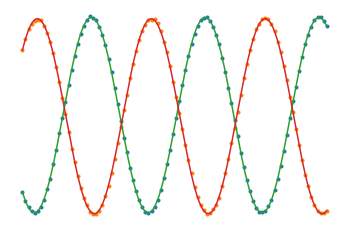

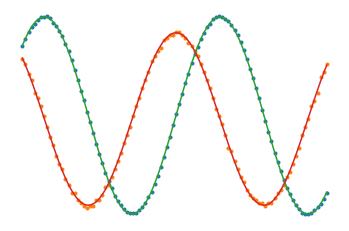

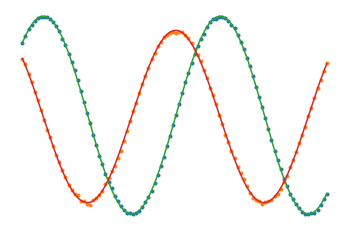

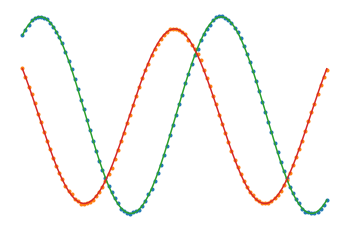

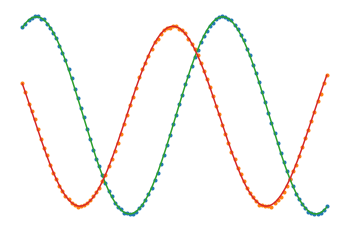

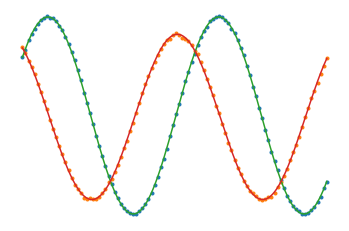

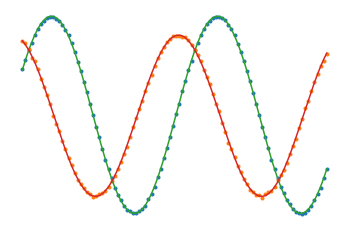

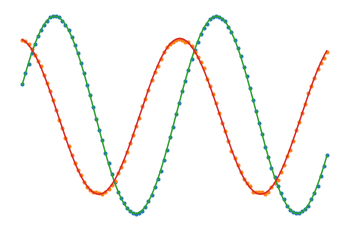

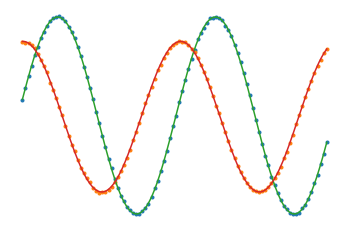

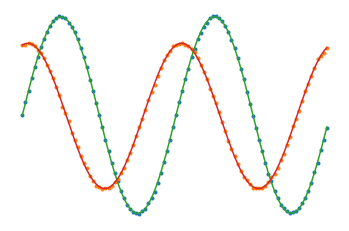

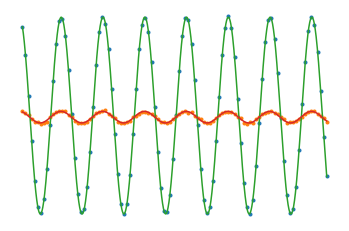

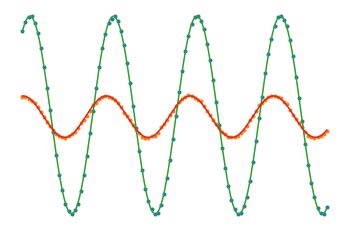

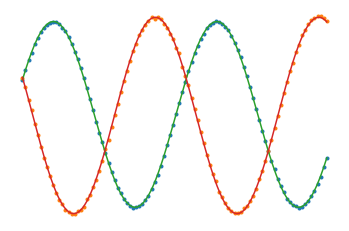

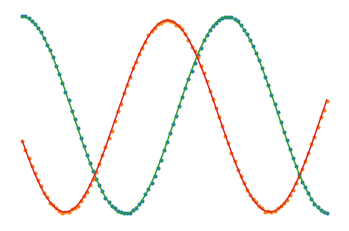

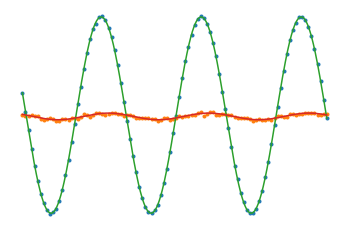

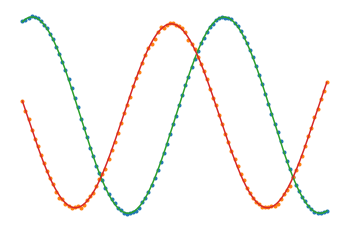

In [286]:
ch_in  = 'CHAN1'
ch_out = 'CHAN4'

AMPS   = list()
i=0
for freq in db.sheet_names:
    fig = plt.figure()
    plt.axis(False)
    
    data = sheets[freq] 
    
    popti, pcov = curve_fit(fit_func, data['Time (Secs)'], data[ch_in] , p0=[0.5, 6*freqs[i], 0, 0])
    popto, pcov = curve_fit(fit_func, data['Time (Secs)'], data[ch_out], p0=[0.5, 6*freqs[i], 0, 0])

    plt.plot(data['Time (Secs)'], data[ch_in] , '.', label=ch_in )
    plt.plot(data['Time (Secs)'], data[ch_out], '.', label=ch_out)
    
    db_time = list(data['Time (Secs)'])
    time = np.linspace(db_time[0], db_time[-1], 1000)

    plt.plot(time, fit_func(time, popti[0], popti[1], popti[2], popti[3]))
    plt.plot(time, fit_func(time, popto[0], popto[1], popto[2], popto[3]))
    
    AMPS.append(abs(popti[0])/abs(popto[0]))
    
    i += 1

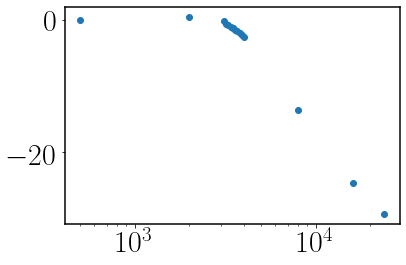

In [287]:
AMPS = [y for x,y in sorted(zip(freqs,AMPS))]
freqs.sort()

fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(freqs, [-20*np.log10(AMP) for AMP in AMPS], 'o')

## T1(s)

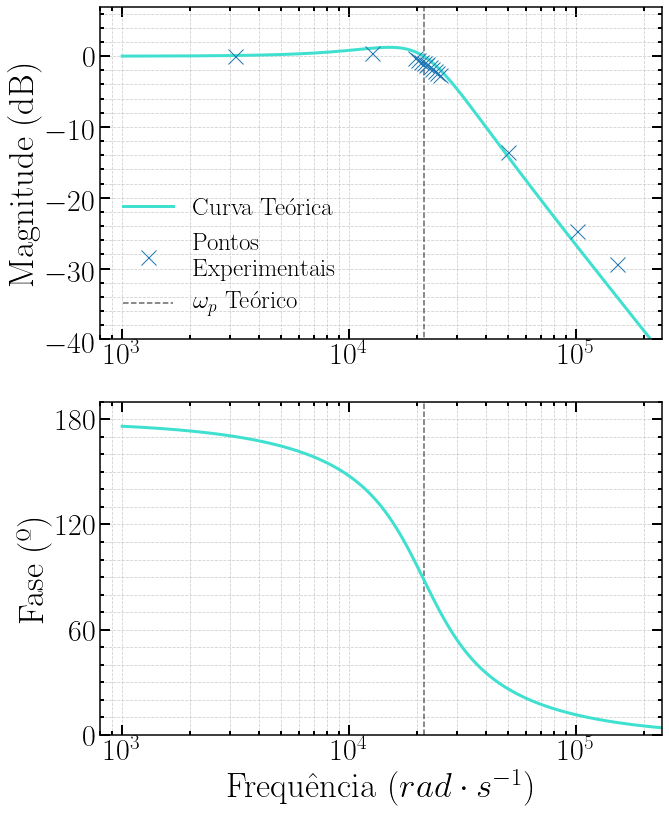

In [288]:
mag,phase,omega = control.bode(G, dB=True, plot=False)
phase = phase - [phase[-1]]

fig = plt.figure()
fig.set_size_inches(10, 12)

ax1 = fig.add_subplot(2, 1, 1)
#plt.title('Diagrama de Bode')

ax2 = fig.add_subplot(2, 1, 2)
plt.xlabel(r'Frequência ($rad \cdot s^{-1}$)')

#RESULTADOS TEÓRICOS
ax1.plot(omega, 20*np.log10(mag) , lw=3, color='turquoise', label='Curva Teórica')
ax2.plot(omega, phase*180/(np.pi), lw=3, color='turquoise')
#DADOS EXPERIMENTAIS
ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], 'x', label='Pontos \nExperimentais', markersize=15)

ax1.vlines(wp, -70, 7, lw=1.5, linestyle='--', label=r'$\omega_p$ Teórico', alpha=0.6)
ax1.set_ylim(-40, 7)
ax1.set_xlim(8*1e2, 2.4*1e5)

ax2.vlines(wp, 0, 190, lw=1.5, linestyle='--', alpha=0.6)
ax2.set_ylim(0, 190)
ax2.set_xlim(8*1e2, 2.4*1e5)


#GRAPHICS SHITS
ax1.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax1.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
ax1.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax1.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

ax2.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax2.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
ax2.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax2.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))

ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(60))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))

ax1.set_ylabel('Magnitude (dB)')
ax2.set_ylabel('Fase (º)')

ax1.legend(frameon=False, fontsize = 25, loc = 'lower left')

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.grid(True, which="both", linestyle='--', alpha=0.6)
ax2.grid(True, which="both", linestyle='--', alpha=0.6)

fig.tight_layout()
fig.savefig('T3_2.pdf')

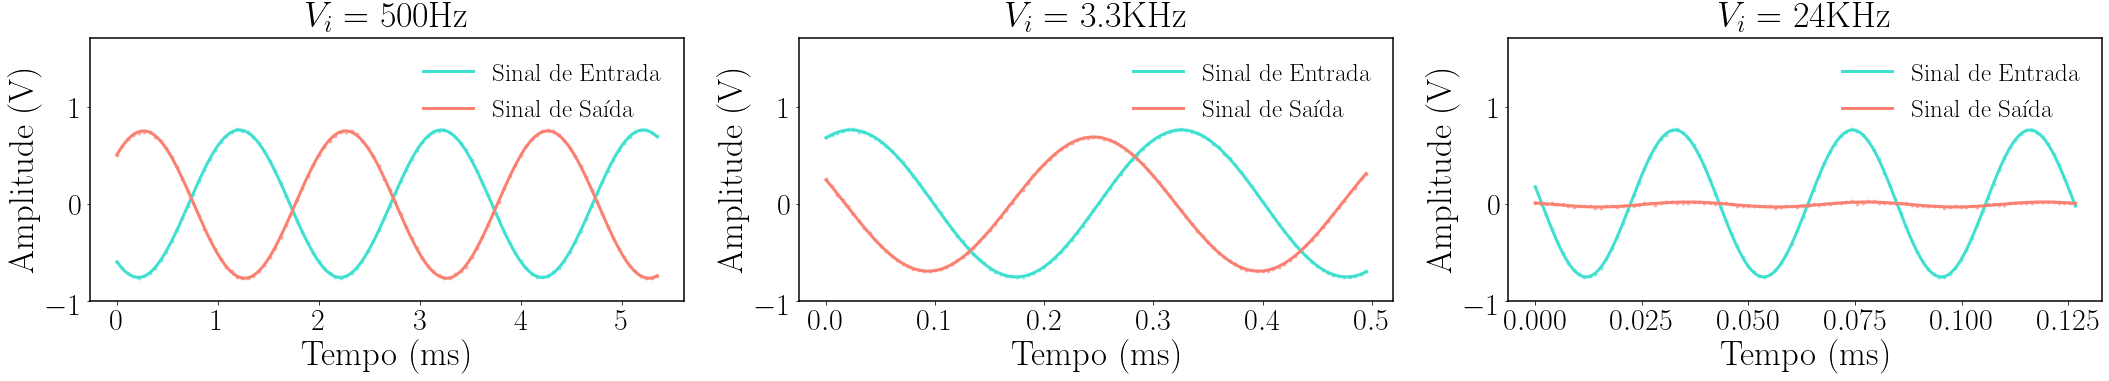

In [315]:
ch_in  = 'CHAN1'
ch_out = 'CHAN4'

freqs_ = [500, 3.3*k, 24*k]
i = 0

fig = plt.figure()
fig.set_size_inches(30, 6)

for freq in ['500Hz', '3.3KHz', '24KHz']:
    ax  = fig.add_subplot(1, 3, i + 1)
    
    data = sheets[freq]
    
    if freq == '500HZ':
        freq = '500Hz'
        
    data_time = 1000*(data['Time (Secs)'] - data['Time (Secs)'][0])
    
    popti, pcov = curve_fit(fit_func, data_time, data[ch_in] , p0=[0.5, 6*freqs_[i]/1000, 0, 0])
    popto, pcov = curve_fit(fit_func, data_time, data[ch_out], p0=[0.5, 6*freqs_[i]/1000, 0, 0])

    ax.plot(data_time, data[ch_in] , '.', color='turquoise', alpha=0.5)
    ax.plot(data_time, data[ch_out], '.', color='salmon'   , alpha=0.5)
    
    time = np.linspace(list(data_time)[0], list(data_time)[-1], 1000)

    ax.plot(time, fit_func(time, popti[0], popti[1], popti[2], popti[3]), color='turquoise', lw = 3, label='Sinal de Entrada')
    ax.plot(time, fit_func(time, popto[0], popto[1], popto[2], popto[3]), color='salmon'   , lw = 3, label='Sinal de Saída')
    
    ax.set_ylim(-1, 1.7)
    
    ax.set_xlabel('Tempo (ms)')
    ax.set_ylabel('Amplitude (V)')
    
    ax.set_title(r'$V_{i} = $ ' + freq)
    ax.legend(loc='upper right', frameon=False, fontsize=25)
    
    i += 1

plt.tight_layout()
plt.savefig('T3_FILT_2.pdf')

Vários Bodes, para quando se varia o valor do Potenciómetro

DADOS/GRUPO 7 2a SESSAO R=10KOhm.xlsx


/Users/thomasgaehtgens/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


DADOS/GRUPO 7 2a SESSAO R=5KOhm.xlsx
DADOS/GRUPO 7 2a SESSAO R=1KOhm.xlsx
DADOS/GRUPO 7 2a SESSAO R=0.5KOhm.xlsx


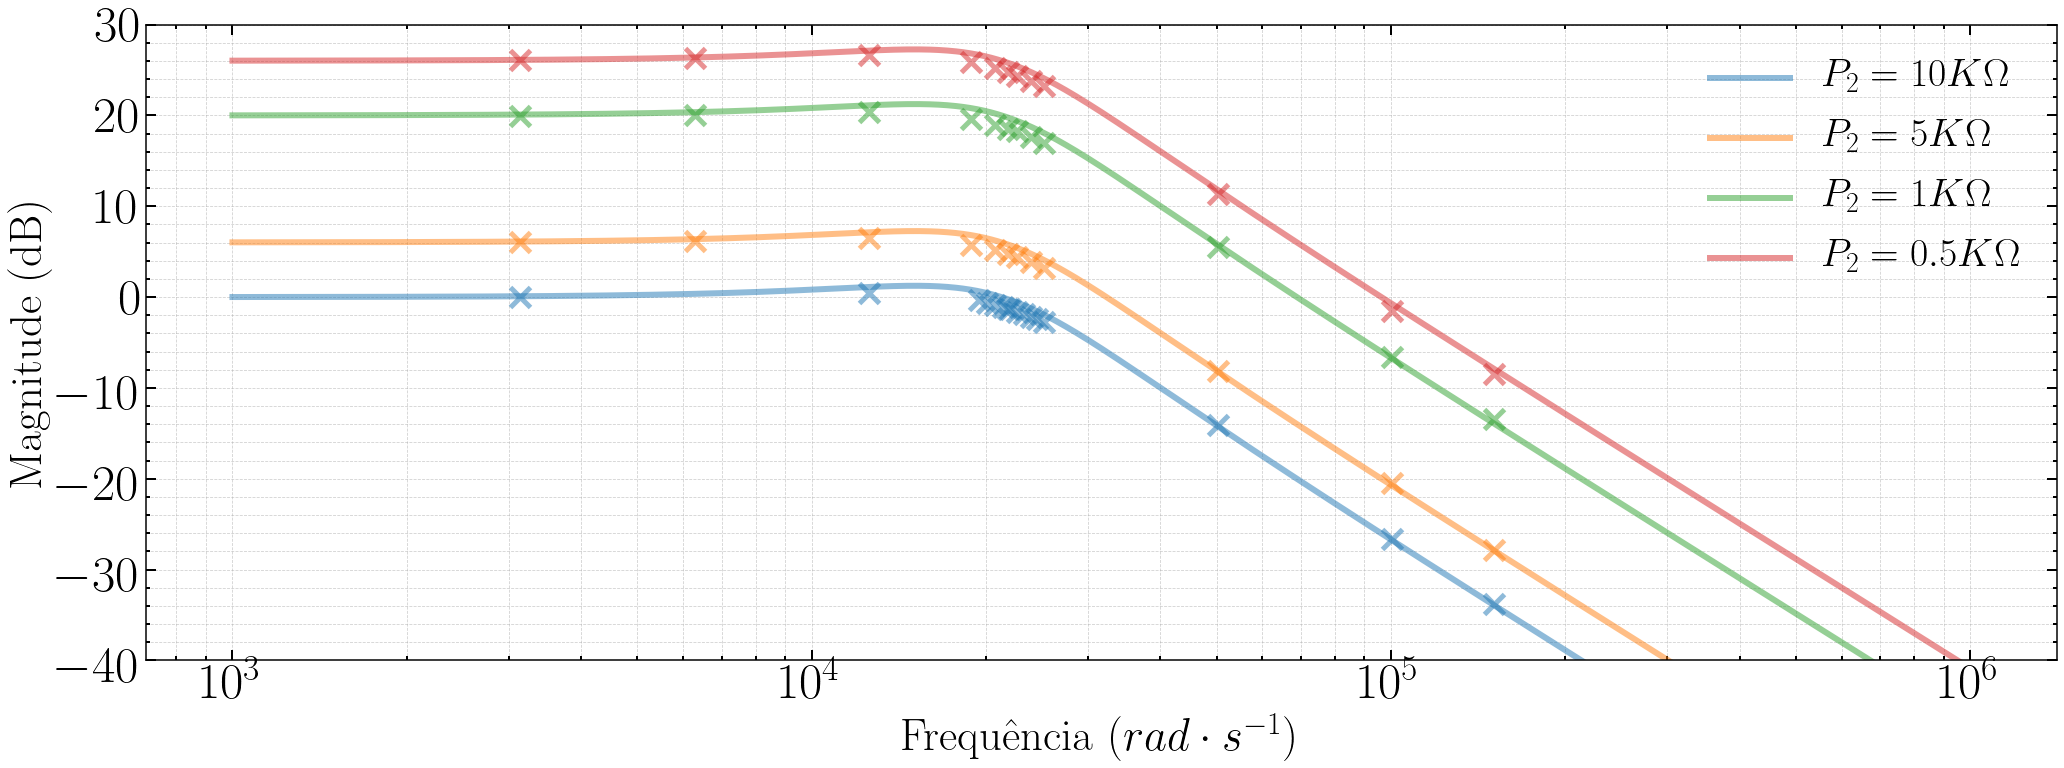

In [365]:
P2_vals      = [10*k, 5*k, k, 0.5*k]
sheet_names  = [i for i in db.sheet_names]
fig = plt.figure()
fig.set_size_inches(30, 12)

plt.xlabel(r'Frequência ($rad \cdot s^{-1}$)', fontsize = 1.5*30)
labels = [r'$P_{2} = 10K \Omega$', r'$P_{2} = 5K \Omega$', r'$P_{2} = 1K \Omega$', r'$P_{2} = 0.5K \Omega$']

plt.rcParams['font.size'] = 1.7*30

ch_in  = 'CHAN1'
ch_out = 'CHAN3'

i = 0
for P2 in P2_vals:
    
    path  = paths[i]
    print(path)

    db     = pd.ExcelFile(path)
    sheets = dict() #DICIONÁRIO COM AS FOLHAS

    for freq in db.sheet_names:
        data = db.parse(freq)[['Time (Secs)', 'CHAN1', 'CHAN2', 'CHAN3', 'CHAN4']]
        sheets[freq] = data
    
    sheet_names = [freq[:-2] for freq in db.sheet_names]

    freqs = list() #LISTA COM OS VALORES DE FREQUÊNCIA
    for freq in sheet_names:
        if freq[-1] == 'K':
            freqs.append(float(freq[:-1])*1e3)
        else:
            freqs.append(float(freq))
    
    AMPS   = list()
    j=0
    for freq in db.sheet_names:
        data = sheets[freq] 

        popti, pcov = curve_fit(fit_func, data['Time (Secs)'], data[ch_in] , p0=[0.5, 6*freqs[j], 0, 0])
        popto, pcov = curve_fit(fit_func, data['Time (Secs)'], data[ch_out], p0=[0.5, 6*freqs[j], 0, 0])

        AMPS.append(abs(popti[0])/abs(popto[0]))

        j += 1
    
    wp = np.sqrt(R5/(C1*C1*R11*R2*R4))
    Q  = wp*C1*R6
    K  = 1/(C1*P2*wp)
    
    #É PRECISO MUDAR ESTA FUNÇÃO PARA CADA CASO ESPECÍFICO
    G = control.tf([-K*wp**2],[1,wp/Q, wp**2])
    
    mag,phase,omega = control.bode(G, dB=True, plot=False)
    phase = phase - [phase[-1]]

    ax1 = fig.add_subplot(1, 1, 1)

    #RESULTADOS TEÓRICOS
    ax1.plot(omega, 20*np.log10(mag) , lw=6, label=labels[i], alpha=0.5)
    
    #RESULTADOS EXPERIMENTAIS
    AMPS = [y for x,y in sorted(zip(freqs,AMPS))]
    freqs.sort()

    ax1.plot([freq*2*np.pi for freq in freqs], [-20*np.log10(AMP) for AMP in AMPS], 'x', markersize=20, mew=5, color='C'+str(i), alpha=0.5)

    #GRAPHICS SHITS
    ax1.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
    ax1.xaxis.set_tick_params(which='minor', size=4, width=2, direction='in', top='on')
    ax1.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax1.yaxis.set_tick_params(which='minor', size=4, width=2, direction='in', right='on')

    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
    ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
    
    ax1.set_ylim(-40, 30)

    ax1.set_ylabel('Magnitude (dB)', fontsize = 30*1.5)

    ax1.legend(frameon=False, fontsize = 40, loc = 'upper right')

    ax1.set_xscale('log')
    ax1.grid(True, which="both", linestyle='--', alpha=0.6)
    
    i+= 1

fig.tight_layout()
fig.savefig('var_P2_T3.pdf')